#Draft


In [1]:
# from datasets import load_dataset

# ds = load_dataset("phantatbach/TMed")

In [2]:
# print(ds)
# print(ds["train"].features)
# print(ds['train'][0])

In [3]:
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("xiaoweixumedicalai/cardiacudc-dataset")

# print("Path to dataset files:", path)

In [4]:
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("shoybhasan/camus-human-heart-data")

# print("Path to dataset files:", path)

In [5]:
# !file /kaggle/input/camus-human-heart-data/download
# !ls
# !mv download camus.zip
# !unzip camus.zip -d camus_dataset


In [6]:
# !zip -r output_filename.zip /root/.cache/kagglehub/datasets

In [7]:
# from google.colab import drive
# drive.mount('/content/drive')

# !cp output_filename.zip /content/drive/MyDrive/


In [8]:
# import urllib.parse
# import IPython.display as display

# file_path = '/content/output_filename.zip'
# file_name = file_path.split('/')[-1]

# # Encode the path for the link
# encoded_path = urllib.parse.quote(file_path)

# # This is the actual temporary download URL Colab uses
# url = f'/download/{encoded_path}'

# # Show it as a clickable link
# display.HTML(f'<a href="{url}" target="_blank">Click here for direct download</a>')


In [9]:
# !wget -r -N -c -np --user mehran8 --ask-password https://physionet.org/files/mimic-iv-echo/0.1/


# HVC

Downloading the data

In [10]:
import requests
import zipfile
import os

def download_file(url, extract_to="."):
    filename = url.split("/")[-1]  # get filename from URL

    print(f"Downloading {filename}...")
    response = requests.get(url)
    response.raise_for_status()  # ensure download was successful

    # Save the file
    with open(filename, "wb") as f:
        f.write(response.content)

    # If it's a ZIP, extract it
    if filename.endswith(".zip"):
        print(f"Extracting {filename}...")
        with zipfile.ZipFile(filename, "r") as zip_ref:
            zip_ref.extractall(extract_to)
        print(f"Extracted to {extract_to}")
    else:
        print(f"Saved {filename}")

# Example usage (replace with your actual URLs)
url1 = "https://data.unityimaging.net/files/2020-12-05/png-cache.zip"
url2 = "https://data.unityimaging.net/files/additional/view_index_20220705.csv"

download_file(url1, extract_to="data1")
download_file(url2, extract_to="data2")


Extracting png-cache.zip...
Extracted to data1
Saved view_index_20220705.csv


Preprocessing

In [11]:
import os
import pandas as pd
from PIL import Image
from tqdm import tqdm

root_dir = "/content/data1/png-cache/01"   # Unity dataset root
csv_file = "/content/view_index_20220705.csv"
output_dir = "dataset_cleaned"
os.makedirs(output_dir, exist_ok=True)

df = pd.read_csv(csv_file)
label_map = dict(zip(df['file'], df['view']))  # adjust if columns differ

target_size = (224, 224)

for fname, view in tqdm(label_map.items()):
    # locate file in nested folders
    sub1, sub2 = fname[3:5], fname[5:7]
    fpath = os.path.join(root_dir, sub1, sub2, fname)
    if not os.path.exists(fpath):
        # print(f"missing: {fpath}")
        continue  # skip if file missing

    # open
    img = Image.open(fpath).convert("RGB")
    w, h = img.size

    # dynamic crop (50 top/bottom, 100 left/right)
    left, top, right, bottom = 100, 50, w-100, h-50
    img = img.crop((left, top, right, bottom))

    # resize
    img = img.resize(target_size)

    # save in clean folder
    outdir = os.path.join(output_dir, view)
    os.makedirs(outdir, exist_ok=True)
    img.save(os.path.join(outdir, fname))


100%|██████████| 15500/15500 [02:30<00:00, 102.85it/s]


Splitting the dataset

In [12]:
import os
import shutil
import random

# --- Paths ---
dataset_dir = "/content/dataset_cleaned"   # current dataset (all images per class)
output_dir = "dataset_split"      # new split dataset

# --- Split ratios ---
train_ratio, val_ratio, test_ratio = 0.7, 0.15, 0.15

# --- Fix random seed for reproducibility ---
random.seed(42)

# --- Create output structure ---
for split in ["train", "val", "test"]:
    for cls in os.listdir(dataset_dir):
        os.makedirs(os.path.join(output_dir, split, cls), exist_ok=True)

# --- Split images ---
for cls in os.listdir(dataset_dir):
    class_dir = os.path.join(dataset_dir, cls)
    if not os.path.isdir(class_dir):
        continue

    images = os.listdir(class_dir)
    random.shuffle(images)

    n_total = len(images)
    n_train = int(train_ratio * n_total)
    n_val = int(val_ratio * n_total)

    train_files = images[:n_train]
    val_files = images[n_train:n_train+n_val]
    test_files = images[n_train+n_val:]

    # Move files
    for fname in train_files:
        shutil.copy(os.path.join(class_dir, fname), os.path.join(output_dir, "train", cls, fname))
    for fname in val_files:
        shutil.copy(os.path.join(class_dir, fname), os.path.join(output_dir, "val", cls, fname))
    for fname in test_files:
        shutil.copy(os.path.join(class_dir, fname), os.path.join(output_dir, "test", cls, fname))

    print(f"{cls}: {n_total} → train={len(train_files)}, val={len(val_files)}, test={len(test_files)}")

print("✅ Dataset split completed at:", output_dir)


a2c: 1029 → train=720, val=154, test=155
plax: 2891 → train=2023, val=433, test=435
a4c: 3311 → train=2317, val=496, test=498
a3c: 147 → train=102, val=22, test=23
a5c: 144 → train=100, val=21, test=23
✅ Dataset split completed at: dataset_split


#Data Augmentation

In [13]:
import tensorflow as tf
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import numpy as np

# Augmentation generator
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
)

def augment_class_images(src_dir, out_dir, target_count=2000):
    os.makedirs(out_dir, exist_ok=True)
    files = [f for f in os.listdir(src_dir) if f.endswith(".png")]
    n_existing = len(files)

    if n_existing >= target_count:
        print(f"Skipping {src_dir}, already has {n_existing}")
        return

    i = 0
    for fname in files:
        img_path = os.path.join(src_dir, fname)
        img = Image.open(img_path).convert("RGB")
        arr = np.expand_dims(np.array(img), 0)  # (1, h, w, c)

        # Generate new images
        for batch in datagen.flow(arr, batch_size=1,
                                  save_to_dir=out_dir,
                                  save_prefix="aug",
                                  save_format="png"):
            i += 1
            if n_existing + i >= target_count:
                break
        if n_existing + i >= target_count:
            break
    print(f"Augmented {src_dir} → {n_existing + i} images")


In [14]:
augment_class_images("/content/dataset_split/train/a4c", "/content/dataset_split/train/a4c", target_count=2000)
augment_class_images("/content/dataset_split/train/a3c", "/content/dataset_split/train/a3c", target_count=2000)
augment_class_images("/content/dataset_split/train/a5c", "/content/dataset_split/train/a5c", target_count=2000)
augment_class_images("/content/dataset_split/train/a2c", "/content/dataset_split/train/a2c", target_count=2000)

Skipping /content/dataset_split/train/a4c, already has 2317
Augmented /content/dataset_split/train/a3c → 2000 images
Augmented /content/dataset_split/train/a5c → 2000 images
Augmented /content/dataset_split/train/a2c → 2000 images


# Training and Evaluating

Base modules

In [2]:
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

def evaluate_with_confusion_matrix(model, test_ds, class_names):
    # Get true labels & predictions
    y_true = []
    y_pred = []

    for images, labels in test_ds:
        preds = model.predict(images, verbose=0)
        y_true.extend(labels.numpy())
        y_pred.extend(np.argmax(preds, axis=1))

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

    # Classification Report (precision/recall/F1 per class)
    print(classification_report(y_true, y_pred, target_names=class_names))


# --- Dataset Loader ---
def load_datasets(dataset_dir, img_size=(224,224), batch_size=32):
    raw_train_ds = tf.keras.utils.image_dataset_from_directory(
        os.path.join(dataset_dir, "train"),
        image_size=img_size,
        batch_size=batch_size
    )
    raw_val_ds = tf.keras.utils.image_dataset_from_directory(
        os.path.join(dataset_dir, "val"),
        image_size=img_size,
        batch_size=batch_size
    )
    raw_test_ds = tf.keras.utils.image_dataset_from_directory(
        os.path.join(dataset_dir, "test"),
        image_size=img_size,
        batch_size=batch_size
    )

    # ✅ Capture class names before wrapping
    class_names = raw_train_ds.class_names

    # ✅ Add normalization (scale 0–255 → 0–1)
    # normalization_layer = tf.keras.layers.Rescaling(1./255)
    # train_ds = raw_train_ds.map(lambda x, y: (normalization_layer(x), y))
    # val_ds   = raw_val_ds.map(lambda x, y: (normalization_layer(x), y))
    # test_ds  = raw_test_ds.map(lambda x, y: (normalization_layer(x), y))

    AUTOTUNE = tf.data.AUTOTUNE
    train_ds = raw_train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
    val_ds = raw_val_ds.cache().prefetch(buffer_size=AUTOTUNE)
    test_ds = raw_test_ds.cache().prefetch(buffer_size=AUTOTUNE)

    return train_ds, val_ds, test_ds, class_names


# --- Model Builder ---
def build_model(base_model_fn, img_size, num_classes, dropout_rate=0.2, learning_rate=1e-4):
    base_model = base_model_fn(
        input_shape=img_size + (3,),
        include_top=False,
        weights="imagenet"
    )
    base_model.trainable = False  # freeze

    x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    output = tf.keras.layers.Dense(num_classes, activation="softmax")(x)

    model = tf.keras.Model(inputs=base_model.input, outputs=output)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model


# --- Train + Export Pipeline ---
def train_and_export(model_name, base_model_fn, dataset_dir, out_prefix,
                     img_size=(224,224), batch_size=32, epochs=10):
    print(f"\n🔹 Training {model_name}...")
    train_ds, val_ds, test_ds, class_names = load_datasets(dataset_dir, img_size, batch_size)
    num_classes = len(class_names)
    print("Classes:", class_names)

    model = build_model(base_model_fn, img_size, num_classes)

    history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

    test_loss, test_acc = model.evaluate(test_ds)
    print(f"✅ {model_name} Test Accuracy: {test_acc:.3f}")

    evaluate_with_confusion_matrix(model, test_ds, class_names)

    # Save and export
    tflite_out = f"{out_prefix}.tflite"

    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    tflite_model = converter.convert()

    with open(tflite_out, "wb") as f:
        f.write(tflite_model)

    print(f"✅ {model_name} exported to {tflite_out}")

    return model, history


In [16]:
# import tensorflow as tf
# tf.debugging.set_log_device_placement(False)

Various Models


🔹 Training ResNet50...
Found 9898 files belonging to 5 classes.
Found 1126 files belonging to 5 classes.
Found 1134 files belonging to 5 classes.
Classes: ['a2c', 'a3c', 'a4c', 'a5c', 'plax']
Epoch 1/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 76s 132ms/step - accuracy: 0.4583 - loss: 1.4094 - val_accuracy: 0.7460 - val_loss: 0.7645
Epoch 2/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 39s 88ms/step - accuracy: 0.8414 - loss: 0.4912 - val_accuracy: 0.8162 - val_loss: 0.5919
Epoch 3/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 28s 90ms/step - accuracy: 0.8818 - loss: 0.3666 - val_accuracy: 0.8375 - val_loss: 0.5208
Epoch 4/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 28s 90ms/step - accuracy: 0.9004 - loss: 0.3209 - val_accuracy: 0.8597 - val_loss: 0.4719
Epoch 5/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 28s 90ms/step - accuracy: 0.9033 - loss: 0.2951 - val_accuracy: 0.8641 - val_loss: 0.4382
Epoch 6/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 28s 90ms/step - accuracy: 0.9173 - loss: 0.2607 - val_accuracy: 0.8677 - val_loss: 0.4153
Epoch 7/10
310/310 ━━━━━━━

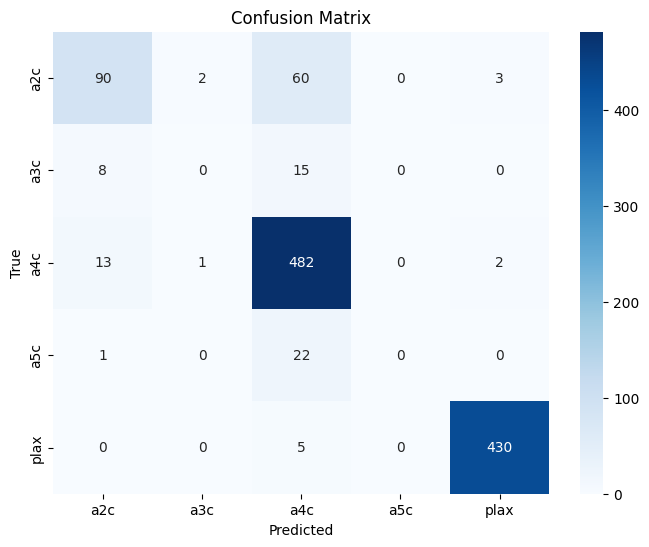

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

         a2c       0.80      0.58      0.67       155
         a3c       0.00      0.00      0.00        23
         a4c       0.83      0.97      0.89       498
         a5c       0.00      0.00      0.00        23
        plax       0.99      0.99      0.99       435

    accuracy                           0.88      1134
   macro avg       0.52      0.51      0.51      1134
weighted avg       0.85      0.88      0.86      1134

Saved artifact at '/tmp/tmp_1133kxs'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  140539329372880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140539329373840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140539329375952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140539329376144

(<Functional name=functional, built=True>,
 <keras.src.callbacks.history.History at 0x7fd1dc95cfe0>)

In [3]:
dataset_dir = "dataset_split"

train_and_export("ResNet50", tf.keras.applications.ResNet50, dataset_dir, "resnet50")

In [18]:
train_and_export("DenseNet121", tf.keras.applications.DenseNet121, dataset_dir, "densenet121")


🔹 Training DenseNet121...
Found 9898 files belonging to 5 classes.
Found 1126 files belonging to 5 classes.
Found 1134 files belonging to 5 classes.
Classes: ['a2c', 'a3c', 'a4c', 'a5c', 'plax']
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 110s 207ms/step - accuracy: 0.2513 - loss: 3.5671 - val_accuracy: 0.5195 - val_loss: 1.2925
Epoch 2/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 24s 78ms/step - accuracy: 0.5064 - loss: 1.6048 - val_accuracy: 0.6199 - val_loss: 1.0287
Epoch 3/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 25s 82ms/step - accuracy: 0.6565 - loss: 1.0464 - val_accuracy: 0.6954 - val_loss: 0.8784
Epoch 4/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 40s 79ms/step - accuracy: 0.7256 - loss: 0.8577 - val_accuracy: 0.7327 - val_loss: 0.7939
Epoch 5/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 41s 80ms/step - accuracy: 0.7625 - loss: 0.7339 - val_accuracy: 0.7584 - val_loss: 0.7321
Epoch 6/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 41s 79ms/step - accuracy: 0.8018 - loss: 0.6172 - val_accurac

(<Functional name=functional_1, built=True>,
 <keras.src.callbacks.history.History at 0x7ba8a5744fe0>)

In [19]:
train_and_export("VGG16", tf.keras.applications.VGG16, dataset_dir, "vgg16") # seems to be unnecessary large with low accuracy


🔹 Training VGG16...
Found 9898 files belonging to 5 classes.
Found 1126 files belonging to 5 classes.
Found 1134 files belonging to 5 classes.
Classes: ['a2c', 'a3c', 'a4c', 'a5c', 'plax']
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 120s 268ms/step - accuracy: 0.2531 - loss: 3.2399 - val_accuracy: 0.5551 - val_loss: 1.3617
Epoch 2/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 89s 212ms/step - accuracy: 0.5889 - loss: 1.4181 - val_accuracy: 0.6963 - val_loss: 0.9434
Epoch 3/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 77s 197ms/step - accuracy: 0.7338 - loss: 0.9333 - val_accuracy: 0.7513 - val_loss: 0.7932
Epoch 4/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 59s 191ms/step - accuracy: 0.7931 - loss: 0.7215 - val_accuracy: 0.7842 - val_loss: 0.7177
Epoch 5/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 60s 194ms/step - accuracy: 0.8273 - loss: 0.6060 - val_accuracy: 0.7975 - val_loss: 0.6613
Epoch 6/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 61s 195ms/step - accuracy: 0.8440 - loss: 0.5277 - val_accuracy

KeyboardInterrupt: 

In [ ]:
train_and_export("MobileNetV2", tf.keras.applications.MobileNetV2, dataset_dir, "mobilenetv2")

In [ ]:
dataset_dir = "dataset_split"

train_and_export("EfficientNetB0", tf.keras.applications.EfficientNetB0, dataset_dir, "efficientnetb0")